# Machine Learning Models

#### 1. Using XGBoost for Defensive Transitions (Defensive Success - Whether the team successfully recovers the ball through a defensive action (tackle, interception, clearance) within 10 seconds after losing possession)

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


df_transitions = pd.read_csv('all_teams_transition_data.csv')

# Print the first few rows to understand the data structure
print("DataFrame preview:")
print(df_transitions.head())

# Check available columns
print("\nAvailable columns:", df_transitions.columns.tolist())

# Modify the prepare_features function to be more careful
def prepare_features(df):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Create derived features based on columns that actually exist
    derived_columns = []
    
    # Distance to goal (if loss_x exists)
    if 'loss_x' in df.columns and 'period_id' in df.columns:
        df['distance_to_goal'] = np.where(
            df['period_id'] % 2 == 1,  # Odd periods (1,3)
            105 - df['loss_x'],         # Distance from right goal
            df['loss_x']                # Distance from left goal
        )
        derived_columns.append('distance_to_goal')
    
    # Create pitch zone features (if loss_x exists)
    if 'loss_x' in df.columns:
        try:
            df['zone_x'] = pd.cut(
                df['loss_x'], 
                bins=[0, 35, 70, 105], 
                labels=['Defensive', 'Middle', 'Attacking']
            )
            derived_columns.append('zone_x')
        except Exception as e:
            print(f"Error creating zone_x: {e}")
            # Check if loss_x contains valid numeric data
            print("loss_x statistics:", df['loss_x'].describe())
    
    # Create time features (if loss_time exists)
    if 'loss_time' in df.columns:
        df['game_minute'] = df['loss_time'] / 60  # Convert to minutes
        derived_columns.append('game_minute')
    
    print(f"Successfully created {len(derived_columns)} derived columns: {derived_columns}")
    return df

# Prepare the data with the columns you actually have
df = prepare_features(df_transitions)

# Define features based on ONLY columns that actually exist in your dataframe
available_columns = set(df.columns)
print("\nColumns after feature engineering:", available_columns)

# Define basic features that should be available
possible_features = [
    'loss_x', 'loss_y', 
    'period_id', 'loss_time',
    'distance_to_goal', 'game_minute'
]

# Use only features that actually exist in the dataframe
features = [f for f in possible_features if f in available_columns]
print("\nFeatures being used:", features)

# Check if we have the target variable
target = 'defensive_success'
if target not in df.columns:
    print(f"\nError: Target column '{target}' not found in DataFrame")
    print("Available columns for potential target:", df.columns.tolist())
    
    # Try to create the target if we have the necessary columns
    if 'result' in df.columns:
        print("Using 'result' column as proxy for defensive success")
        df[target] = (df['result'] == '1') | (df['result'] == 1) | (df['result'] == True)
    else:
        print("Cannot create target variable - stopping execution")
        raise KeyError(f"Target column '{target}' not available and cannot be created")
else:
    print(f"\nTarget column '{target}' found")

# Now continue with the modeling
print("\nPreparing to train model...")

# Drop rows with missing values in the features or target
df_clean = df.dropna(subset=features + [target])
print(f"Data after removing NaNs: {len(df_clean)} rows (dropped {len(df) - len(df_clean)} rows)")

# Check if we have enough data
if len(df_clean) < 10:
    print(f"Warning: Only {len(df_clean)} samples after removing NaN values - not enough to train a model")
else:
    # Split the data
    X = df_clean[features]
    y = df_clean[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    # Train XGBoost model
    print("\nTraining XGBoost model...")
    model = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(f"\nTest accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    
    print("\nModel training complete!")

DataFrame preview:
   loss_event_id                    game_id  period_id  loss_time  \
0             11  5oc8drrbruovbuiriyhdyiyok          1       26.0   
1             11  5oc8drrbruovbuiriyhdyiyok          1       26.0   
2             11  5oc8drrbruovbuiriyhdyiyok          1       26.0   
3             11  5oc8drrbruovbuiriyhdyiyok          1       26.0   
4             11  5oc8drrbruovbuiriyhdyiyok          1       26.0   

            team_losing_ball          team_gaining_ball  loss_x  loss_y  \
0  1oyb7oym5nwzny8vxf03szd2h  b7jmo07lqav0wfe2mtlzyspak   49.77   24.14   
1  1oyb7oym5nwzny8vxf03szd2h  b7jmo07lqav0wfe2mtlzyspak   49.77   24.14   
2  1oyb7oym5nwzny8vxf03szd2h  b7jmo07lqav0wfe2mtlzyspak   49.77   24.14   
3  1oyb7oym5nwzny8vxf03szd2h  b7jmo07lqav0wfe2mtlzyspak   49.77   24.14   
4  1oyb7oym5nwzny8vxf03szd2h  b7jmo07lqav0wfe2mtlzyspak   49.77   24.14   

   action_id  seconds_after_loss  ... start_y   end_x   end_y  \
0         12                 1.0  ...  32.232  70.

#### 2. Promising Data to Cluster and Analyze using K-Means Cluster (didn't work)

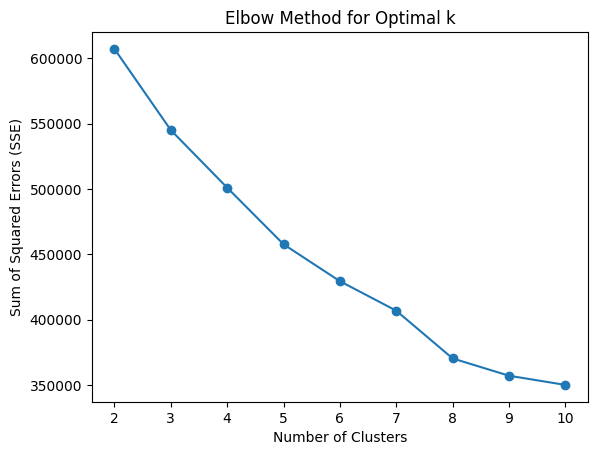

Silhouette Score: 0.13


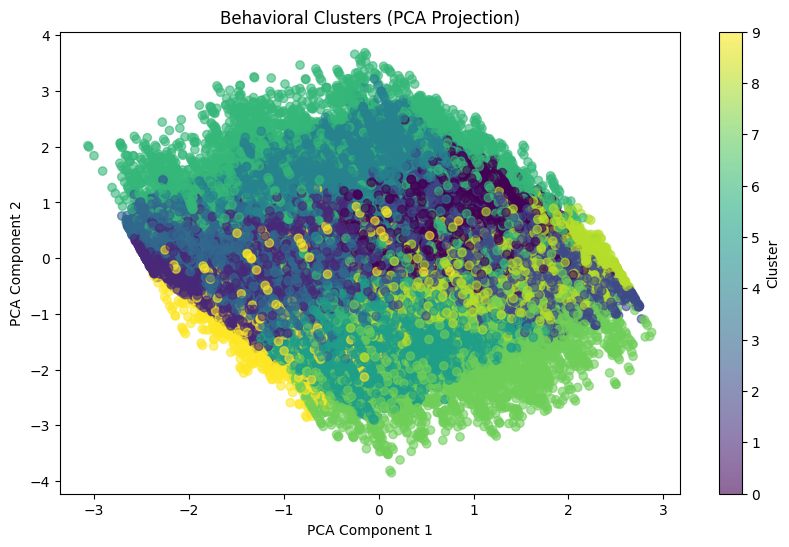

cluster                                   0         1         2         3  \
loss_x                            -0.052107  0.936343 -0.097676  0.169361   
loss_y                             0.900985 -0.711650  0.984404 -1.100601   
seconds_after_loss                -0.660857  0.871244  1.093167 -0.889274   
time_to_defensive_action          -0.010468 -0.018788 -0.020838 -0.007993   
movement_direction_BACKWARD        0.397014  0.421422  0.416552  0.383963   
movement_direction_FORWARD         0.398595  0.418285  0.422929  0.397733   
movement_direction_NEUTRAL         0.204392  0.160293  0.160519  0.218304   
x_sector_ATTACKING_THIRD           0.029600  0.498656  0.220886  0.295987   
x_sector_DEFENSIVE_THIRD           0.028107  0.057365  0.270889  0.153279   
x_sector_MIDDLE_THIRD              0.942292  0.443980  0.508225  0.550734   
y_sector_CENTER                    0.249012  0.353152  0.270237  0.174421   
y_sector_LEFT_WING                 0.021080  0.499552  0.118849  0.816468   

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("all_teams_transition_data.csv")

# =====================================================================
# 1. Select Behavioral Features
# =====================================================================
# Selected features for meaningful transition clusters
numerical_features = [
    'loss_x', 'loss_y', 'seconds_after_loss', 'time_to_defensive_action'
]

categorical_features = [
    'movement_direction', 'x_sector', 'y_sector',
    'successful_defensive_action', 'defensive_success'
]

# Group by team_id first to analyze team-level patterns
team_transition_stats = df.groupby('team_id').agg({
    'movement_direction': lambda x: (x == 'FORWARD').mean(),  # % of forward movements
    'successful_defensive_action': 'mean',  # Success rate
    'time_to_defensive_action': 'mean',  # Avg recovery time
    'defensive_success': 'mean',  # Overall defensive success rate
}).reset_index()

# =====================================================================
# 2. Preprocess Data (Handle Missing Values + Scale + Encode)
# =====================================================================
numeric_imputer = SimpleImputer(strategy="mean")  # Fill NaN in numeric cols with mean
categorical_imputer = SimpleImputer(strategy="most_frequent")  # Fill NaN in categorical cols with mode

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([("imputer", numeric_imputer), ("scaler", StandardScaler())]), numerical_features),
        ('cat', Pipeline([("imputer", categorical_imputer), ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(df)

# =====================================================================
# 3. Determine Optimal Clusters (Elbow Method)
# =====================================================================
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

# =====================================================================
# 4. Apply K-Means Clustering (Replace n_clusters with your choice)
# =====================================================================
n_clusters = 10  # Use the elbow/silhouette analysis to choose this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_processed)

# =====================================================================
# 5. Evaluate Clusters
# =====================================================================
print(f"Silhouette Score: {silhouette_score(X_processed, df['cluster']):.2f}")

# =====================================================================
# 6. Visualize Clusters (2D PCA Projection)
# =====================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title("Behavioral Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

# =====================================================================
# 7. Interpret Clusters
# =====================================================================
# Get feature names after preprocessing
numeric_names = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_features)
categorical_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_names, categorical_names])

# Create a DataFrame of processed features with cluster labels
X_processed_df = pd.DataFrame(X_processed, columns=all_features)
X_processed_df['cluster'] = df['cluster']

# Analyze cluster characteristics
cluster_summary = X_processed_df.groupby('cluster').mean().T
print(cluster_summary)
